<a href="https://colab.research.google.com/github/budennovsk/AuthorBooksComments/blob/master/kion_dataset_v5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [220]:
# !pip install implicit rectools lightfm

In [221]:
#  !pip install gensim

In [222]:
!pip install catboost

In [223]:
!pip install implicit==0.7.2 requests==2.32.3 rectools[lightfm]==0.12.0 pandas==2.2.3 numpy==1.26.4 scipy==1.12.0

In [224]:
import pandas as pd
import requests
from tqdm.auto import tqdm
from pprint import pprint
from implicit.nearest_neighbours import CosineRecommender, TFIDFRecommender
import warnings

from rectools import Columns
from rectools.dataset import Dataset, Interactions
from rectools.metrics import MAP, calc_metrics
from rectools.model_selection import TimeRangeSplitter
from rectools.models import PopularModel, RandomModel, ImplicitItemKNNWrapperModel, PopularInCategoryModel,EASEModel,ImplicitALSWrapperModel, ImplicitBPRWrapperModel,LightFMWrapperModel
from rectools.model_selection import TimeRangeSplitter
from rectools.dataset import Dataset
from rectools.metrics import MeanInvUserFreq, AvgRecPopularity
from implicit.bpr import BayesianPersonalizedRanking
from lightfm import LightFM

from implicit.als import AlternatingLeastSquares


In [225]:
url = 'https://github.com/irsafilo/KION_DATASET/raw/f69775be31fa5779907cf0a92ddedb70037fb5ae/data_original.zip'
req = requests.get(url, stream=True)

with open('kion_train.zip', "wb") as fd:
    total_size_in_bytes = int(req.headers.get('Content-Length', 0))
    progress_bar = tqdm(desc='Downloading the kion dataset...',
                        total=total_size_in_bytes,
                        unit='iB', unit_scale=True)
    for chunk in req.iter_content(chunk_size=2 ** 20):
        progress_bar.update(len(chunk))
        fd.write(chunk)

In [226]:
# !unzip kion_train.zip -x '__MACOSX/*'

In [227]:
interactions = (
    pd.read_csv('data_original/interactions.csv', parse_dates=["last_watch_dt"])
    .rename(columns={'total_dur': Columns.Weight,
                     'last_watch_dt': Columns.Datetime})
)
users = pd.read_csv('data_original/users.csv')
items = pd.read_csv('data_original/items.csv')

### ! если хотите быстро прогнать этот ноутбук - раскомментируйте эти строки - она уменьшает данные
import numpy as np
user_ids = np.random.choice(interactions.user_id.unique(), size=50000, replace=False)
interactions = interactions[interactions.user_id.isin(user_ids)]
###

print(interactions.shape, interactions.user_id.nunique())
interactions.head()

(285128, 5) 50000


,user_id,item_id,datetime,weight,watched_pct
21,931816,11754,2021-06-11,23673,100.0
24,916352,12846,2021-08-12,1812,30.0
32,141674,3813,2021-05-12,129,2.0
38,21723,1819,2021-04-11,8535,100.0
104,570761,9550,2021-06-11,31738,100.0


In [228]:
# 1) Привести колонку к datetime (обязательно, если там строки)
interactions['datetime'] = pd.to_datetime(interactions['datetime'], errors='coerce')
max_date = interactions['datetime'].max()

train = interactions[(interactions['datetime'] <= max_date - pd.Timedelta(days=7))]
test = interactions[(interactions['datetime'] > max_date - pd.Timedelta(days=7))]

# оставляем только теплых пользователей в тесте
test = test[test['user_id'].isin(train['user_id'].unique())]

print(f"train: {train.shape}")
print(f"test: {test.shape}")

train: (262373, 5)
test: (16427, 5)


In [229]:
from rectools.dataset import Dataset

interactions_dataset = Dataset.construct(
    interactions_df=train,
    user_features_df=None,
    item_features_df=None
)

In [230]:
# 1. Создаем PopularModel
pop_model = PopularModel(popularity='n_interactions') #popularity='n_interactions'
pop_model.fit(interactions_dataset)

In [231]:
# Предсказание топ 5 предметов для пользователя
user_id = [1]  # Пример ID пользователя
popular_items = pop_model.recommend(user_id, interactions_dataset,filter_viewed=False, k=10)
popular_items

,user_id,item_id,score,rank
0,1,10440,9744.0,1
1,1,15297,9515.0,2
2,1,9728,6092.0,3
3,1,13865,5968.0,4
4,1,4151,4509.0,5
5,1,3734,3643.0,6
6,1,2657,3367.0,7
7,1,4880,2697.0,8
8,1,142,2324.0,9
9,1,6809,2081.0,10


In [232]:
# Найти предметы с наибольшим score
# Сначала отсортируем по колонке 'score' в порядке убывания
highest_scored_items = popular_items.sort_values(by="score", ascending=False)

# Выведем предметы с максимальным score (весь список или, например, топ-1)
top_item = highest_scored_items.head(10)  # Для случая, когда нужен только один самый лучший предмет
print("Товар с наивысшим score:\n", top_item)

Товар с наивысшим score:
    user_id  item_id   score  rank
0        1    10440  9744.0     1
1        1    15297  9515.0     2
2        1     9728  6092.0     3
3        1    13865  5968.0     4
4        1     4151  4509.0     5
5        1     3734  3643.0     6
6        1     2657  3367.0     7
7        1     4880  2697.0     8
8        1      142  2324.0     9
9        1     6809  2081.0    10


In [233]:
pop_recs_1 = popular_items.merge(items[['item_id', 'title']],
                           on='item_id',
                           how='left')
pop_recs_1

,user_id,item_id,score,rank,title
0,1,10440,9744.0,1,Хрустальный
1,1,15297,9515.0,2,Клиника счастья
2,1,9728,6092.0,3,Гнев человеческий
3,1,13865,5968.0,4,Девятаев
4,1,4151,4509.0,5,Секреты семейной жизни
5,1,3734,3643.0,6,Прабабушка легкого поведения
6,1,2657,3367.0,7,Подслушано
7,1,4880,2697.0,8,Афера
8,1,142,2324.0,9,Маша
9,1,6809,2081.0,10,Дуров


In [234]:
pop_recs = pop_model.recommend(
    test.user_id.unique(),
    dataset=interactions_dataset,
    k=10,
    filter_viewed=False  # True - удаляет просмотренные айтемы из рекомендаций
)

pop_recs = pop_recs.merge(items[['item_id', 'title']],
                               on='item_id',
                               how='left')
pop_recs.head(10)

,user_id,item_id,score,rank,title
0,649830,10440,9744.0,1,Хрустальный
1,649830,15297,9515.0,2,Клиника счастья
2,649830,9728,6092.0,3,Гнев человеческий
3,649830,13865,5968.0,4,Девятаев
4,649830,4151,4509.0,5,Секреты семейной жизни
5,649830,3734,3643.0,6,Прабабушка легкого поведения
6,649830,2657,3367.0,7,Подслушано
7,649830,4880,2697.0,8,Афера
8,649830,142,2324.0,9,Маша
9,649830,6809,2081.0,10,Дуров


In [235]:
# популярность признаку genres
# items["genre"] = items["genres"].str.split(",")
items["genre"] = items["genres"].str.lower().str.split(r"\s*,\s*")
items[["genre", "genres","item_id"]].head()

,genre,genres,item_id
0,"[драмы, зарубежные, детективы, мелодрамы]","драмы, зарубежные, детективы, мелодрамы",10711
1,"[зарубежные, приключения, комедии]","зарубежные, приключения, комедии",2508
2,"[криминал, зарубежные, триллеры, боевики, коме...","криминал, зарубежные, триллеры, боевики, комедии",10716
3,"[драмы, зарубежные, мелодрамы]","драмы, зарубежные, мелодрамы",7868
4,"[драмы, спорт, советские, мелодрамы]","драмы, спорт, советские, мелодрамы",16268


In [236]:
# делаем flatten представление фичи жанров
genre_feature = items[["item_id", "genre"]].explode("genre")
genre_feature.columns = ["id", "value"]
genre_feature["feature"] = "genre"
genre_feature.head()

,id,value,feature
0,10711,драмы,genre
0,10711,зарубежные,genre
0,10711,детективы,genre
0,10711,мелодрамы,genre
1,2508,зарубежные,genre


In [237]:
cc = genre_feature['value'].value_counts()
small_genres = cc[cc <= 50].index  # можно без .tolist()
genre_feature.loc[genre_feature['value'].isin(small_genres), 'value'] = 'other'
len(small_genres)

46

In [238]:
genre_feature[genre_feature['value']=='other']

,id,value,feature
12,4778,other,genre
19,15261,other,genre
70,4547,other,genre
87,1314,other,genre
87,1314,other,genre
...,...,...,...
15859,4902,other,genre
15894,12765,other,genre
15896,15557,other,genre
15914,5870,other,genre


In [239]:
genre_feature = genre_feature[genre_feature['id'].isin(train['item_id'])]
genre_feature

,id,value,feature
1,2508,зарубежные,genre
1,2508,приключения,genre
1,2508,комедии,genre
8,9853,криминал,genre
8,9853,детективы,genre
...,...,...,...
15960,10632,криминал,genre
15961,4538,драмы,genre
15961,4538,спорт,genre
15961,4538,криминал,genre


In [240]:
# Process item features to the form of a flatten dataframe
cols = ['item_id','genres','content_type','title','countries','age_rating']

# Если нужно заменить и пустые строки/пробелы:
items_diff = items[cols].replace(r'^\s*$', np.nan, regex=True).fillna('unknown')

items_train = items_diff.loc[items_diff[Columns.Item].isin(train[Columns.Item])].copy()
def prepare_item_features(item_features):
    """
    Подготовка фичей items в формате как нужно rectools
    """
    new_df = pd.DataFrame()
    items = item_features.copy()

    genres = items[['genres','item_id']].copy()
    genres['genres'] = genres['genres'].str.replace(' +','',regex=True).str.split(',')
    genres = genres.explode('genres')
    # небольшая предобработка похожих жанров
    genres['genres'] = genres['genres'].replace({'советские':'русские','единоборства':'спорт','мультфильмы':'мультфильм',
                                                 'фильм-нуар':'детективы','фитнес':'спорт','историческое':'исторические',
                                                 'западныемультфильмы':'мультфильм','мультсериалы':'мультфильм','воспитаниедетей':'развитие',
                                                 'русскиемультфильмы':'мультфильм','18+':'длявзрослых','анимация':'мультфильм',
                                                'покомиксам':'фантастика'})
    cc = genres['genres'].value_counts(normalize=True)

    # если жанк редкий и встречается менее чем в 5% items - заполним их тэгом other
    small_genres = cc[cc <= 0.05].index.tolist()
    genres.loc[genres['genres'].isin(cc),'genres'] = 'other'
    genres.drop_duplicates(inplace=True)
    genres['feature'] = 'genre'
    genres['weight'] = 1
    new_df = pd.concat([new_df,genres.rename(columns={'genres':'value'})],ignore_index=True)

    ages = items[['item_id','age_rating']].rename(columns={'age_rating':'value'}).copy()
    ages['feature'] = 'age_rating'
    ages['weight'] = 1
    new_df = pd.concat([new_df,ages],ignore_index=True)

    ages = items[['item_id','content_type']].rename(columns={'content_type':'value'}).copy()
    ages['feature'] = 'content_type'
    ages['weight'] = 1
    new_df = pd.concat([new_df,ages],ignore_index=True)

    countries = items[['countries','item_id']].copy()
    countries['countries'] = countries['countries'].str.replace(' +','',regex=True).str.split(',')
    countries = countries.explode('countries')
    # небольшая предобработка похожих стран
    countries['countries'] = countries['countries'].replace({'СССР':'Россия'})
    cc = countries['countries'].value_counts(normalize=True)

    # если эта страна редкая и встречается менее чем в 5% items - заполним их тэгом other
    small_countries = cc[cc <= 0.05].index.tolist()
    countries.loc[countries['countries'].isin(cc),'countries'] = 'other'
    countries.drop_duplicates(inplace=True)
    countries['feature'] = 'countries'
    countries['weight'] = 1
    new_df = pd.concat([new_df,countries.rename(columns={'countries':'value'})],ignore_index=True)

    return new_df.rename(columns={'item_id':'id'})
item_features_train = prepare_item_features(items_train)
item_features_train

,value,id,feature,weight
0,зарубежные,2508,genre,1
1,приключения,2508,genre,1
2,комедии,2508,genre,1
3,криминал,9853,genre,1
4,детективы,9853,genre,1
...,...,...,...,...
47436,Германия,6443,countries,1
47437,Россия,2367,countries,1
47438,Россия,10632,countries,1
47439,Россия,4538,countries,1


In [241]:
# Process item features to the form of a flatten dataframe
cols = ['user_id',"age","sex","kids_flg"]

# Если нужно заменить и пустые строки/пробелы:
users_diff = users[cols].replace(r'^\s*$', np.nan, regex=True).fillna('unknown')

user_train = users_diff.loc[users_diff[Columns.User].isin(train[Columns.User])].copy()
def prepare_user_features(users,cols=["age","sex","kids_flg"]):
    """
    Подготовка фичей пользователей в формате как нужно rectools
    """
    new_df = pd.DataFrame(columns=["feature","value","weight"])
    for col in cols:
        tr_df = users[[col,"user_id"]].copy()
        tr_df.rename(columns={col:"value","user_id":"id"},inplace=True)
        tr_df['weight'] = 1
        tr_df['feature'] = col
        new_df = pd.concat([new_df,tr_df],ignore_index=True)
        new_df['id'] =  new_df['id'].astype(int)
    return new_df
user_features_train=prepare_user_features(user_train)
user_features_train

,feature,value,weight,id
0,age,age_25_34,1,973171
1,age,age_35_44,1,628684
2,age,age_25_34,1,380396
3,age,age_25_34,1,580104
4,age,age_35_44,1,762879
...,...,...,...,...
109729,kids_flg,0,1,424813
109730,kids_flg,0,1,389744
109731,kids_flg,0,1,567837
109732,kids_flg,0,1,137552


In [242]:
# user_features_train[user_features_train['id']==721985]

In [243]:
# users[users['user_id']==721985]

In [244]:
dataset_feature_pop = Dataset.construct(
    interactions_df=train,
    user_features_df=None,
    item_features_df=genre_feature,
    cat_item_features=['genre']
)

In [245]:
dataset_feature_light_FM = Dataset.construct(
    interactions_df=train,
    user_features_df=None,
    item_features_df=genre_feature,
    cat_item_features=['genre'],
    make_dense_user_features=False
)

In [246]:
dataset_feature_light_FM_all_features = Dataset.construct(
    interactions_df=train,
    user_features_df= user_features_train,
    item_features_df=item_features_train,
    cat_user_features=['age', 'sex', 'kids_flg'],
    cat_item_features=['genre', 'age_rating', 'content_type', 'countries'],
    make_dense_user_features=False
)

In [247]:
from rectools.models.popular_in_category import PopularInCategoryModel

pop_cat = PopularInCategoryModel(category_feature='genre', n_categories=5)
pop_cat.fit(dataset_feature_pop);

In [248]:
pop_recs_cat = pop_cat.recommend(
    test.user_id.unique(),
    dataset=dataset_feature_pop,
    k=10,
    filter_viewed=False
)

In [249]:
pop_recs_cat = pop_recs_cat.merge(items[['item_id', 'title']],
                                   on='item_id',
                                   how='left')

pop_recs_cat.head(10)

,user_id,item_id,score,rank,title
0,141674,15297,9515.0,1,Клиника счастья
1,141674,10440,9744.0,2,Хрустальный
2,141674,4151,4509.0,3,Секреты семейной жизни
3,141674,849,691.0,4,Дебошир
4,141674,7829,932.0,5,Поступь хаоса
5,141674,13865,5968.0,6,Девятаев
6,141674,9728,6092.0,7,Гнев человеческий
7,141674,3734,3643.0,8,Прабабушка легкого поведения
8,141674,2657,3367.0,9,Подслушано
9,141674,4880,2697.0,10,Афера


In [250]:
# model_ease = EASEModel(regularization=500)
# model_ease.fit(interactions_dataset);

In [251]:
# ease_recs = model_ease.recommend(
#     test.user_id.unique(),
#     dataset=interactions_dataset,
#     k=10,
#     filter_viewed=False  # True - удаляет просмотренные айтемы из рекомендаций
# )

# ease_recs = ease_recs.merge(items[['item_id', 'title']],
#                                on='item_id',
#                                how='left')
# ease_recs.head(10)

In [252]:
model_iALS = ImplicitALSWrapperModel(
    AlternatingLeastSquares(
        factors=10,  # latent embeddings size
        regularization=0.1,
        iterations=10,
        alpha=50,  # confidence multiplier for non-zero entries in interactions
        random_state=42,
    ),
    fit_features_together=False,  # way to fit paired features
)
model_iALS.fit(interactions_dataset);

In [253]:
model_iALS.get_config()

{'cls': rectools.models.implicit_als.ImplicitALSWrapperModel,
 'verbose': 0,
 'model': {'cls': 'AlternatingLeastSquares',
  'factors': 10,
  'regularization': 0.1,
  'alpha': 50.0,
  'dtype': dtype('float32'),
  'use_native': True,
  'use_cg': True,
  'use_gpu': False,
  'iterations': 10,
  'calculate_training_loss': False,
  'num_threads': 0,
  'random_state': 42},
 'fit_features_together': False,
 'recommend_n_threads': None,
 'recommend_use_gpu_ranking': None}

In [254]:
iALS_recs = model_iALS.recommend(
    test.user_id.unique(),
    dataset=interactions_dataset,
    k=10,
    filter_viewed=False  # True - удаляет просмотренные айтемы из рекомендаций
)

iALS_recs = iALS_recs.merge(items[['item_id', 'title']],
                               on='item_id',
                               how='left')
iALS_recs.head(10)

,user_id,item_id,score,rank,title
0,649830,15731,1.053727,1,Все в сад!
1,649830,822,1.051957,2,Качели
2,649830,14796,1.016989,3,М - убийство
3,649830,9134,1.010637,4,Анна Франк. Параллельные истории
4,649830,14404,0.991199,5,Красный воробей
5,649830,7369,0.975079,6,Панацея
6,649830,16307,0.962087,7,Разорванный круг
7,649830,8625,0.938941,8,Бельканто
8,649830,1462,0.905359,9,[4К] 5 % биоразнообразия Земли
9,649830,11359,0.902682,10,Триумфальная арка


In [255]:
model_iALS_Bpr = ImplicitBPRWrapperModel(
     BayesianPersonalizedRanking(
        factors=10,  # latent embeddings size
        regularization=0.1,
        iterations=10,
        # alpha=50,  # confidence multiplier for non-zero entries in interactions
        random_state=42,
    )
    # fit_features_together=False,  # way to fit paired features
)
model_iALS_Bpr.fit(interactions_dataset);

In [256]:
iALS_recs_BPR = model_iALS_Bpr.recommend(
    test.user_id.unique(),
    dataset=interactions_dataset,
    k=10,
    filter_viewed=False  # True - удаляет просмотренные айтемы из рекомендаций
)

iALS_recs_BPR  = iALS_recs_BPR.merge(items[['item_id', 'title']],
                               on='item_id',
                               how='left')
iALS_recs_BPR.head(10)

,user_id,item_id,score,rank,title
0,649830,10440,0.287317,1,Хрустальный
1,649830,9728,0.216773,2,Гнев человеческий
2,649830,15297,0.214742,3,Клиника счастья
3,649830,3734,0.180694,4,Прабабушка легкого поведения
4,649830,13104,0.169181,5,Малыш на драйве
5,649830,13683,0.162900,6,Смешарики. Новые приключения
6,649830,11179,0.157223,7,Команда Дино. Исследователи
7,649830,7606,0.155432,8,10 этаж
8,649830,12189,0.147950,9,Сказочный патруль
9,649830,3334,0.144176,10,Суперфорсаж


In [257]:
model_LightFM = LightFMWrapperModel(
     LightFM(
        no_components=10,
        loss="warp",
        random_state=42,
    )

)
model_LightFM.fit(interactions_dataset);

In [258]:
LightFM_recs= model_LightFM.recommend(
    test.user_id.unique(),
    dataset=interactions_dataset,
    k=10,
    filter_viewed=False  # True - удаляет просмотренные айтемы из рекомендаций
)

LightFM_recs = LightFM_recs.merge(items[['item_id', 'title']],
                               on='item_id',
                               how='left')
LightFM_recs.head(10)

,user_id,item_id,score,rank,title
0,649830,10440,2.287346,1,Хрустальный
1,649830,15297,2.260607,2,Клиника счастья
2,649830,13865,2.102603,3,Девятаев
3,649830,9728,2.089346,4,Гнев человеческий
4,649830,4151,1.980263,5,Секреты семейной жизни
5,649830,3734,1.920989,6,Прабабушка легкого поведения
6,649830,2657,1.883674,7,Подслушано
7,649830,4880,1.826993,8,Афера
8,649830,142,1.736633,9,Маша
9,649830,6809,1.716949,10,Дуров


In [259]:
model_LightFM_features = LightFMWrapperModel(
     LightFM(
        no_components=10,
        loss="warp",
        random_state=42,
    )

)
model_LightFM_features.fit(dataset_feature_light_FM);

In [260]:
LightFM_recs_features= model_LightFM_features.recommend(
    test.user_id.unique(),
    dataset=dataset_feature_light_FM,
    k=10,
    filter_viewed=False  # True - удаляет просмотренные айтемы из рекомендаций
)

LightFM_recs_features = LightFM_recs_features.merge(items[['item_id', 'title']],
                               on='item_id',
                               how='left')
LightFM_recs_features.head(10)

,user_id,item_id,score,rank,title
0,649830,15297,2.692340,1,Клиника счастья
1,649830,13865,2.576283,2,Девятаев
2,649830,10440,2.553503,3,Хрустальный
3,649830,9728,2.502415,4,Гнев человеческий
4,649830,4151,2.470091,5,Секреты семейной жизни
5,649830,3734,2.365990,6,Прабабушка легкого поведения
6,649830,4880,2.241419,7,Афера
7,649830,2657,2.231582,8,Подслушано
8,649830,12192,2.096498,9,Фемида видит
9,649830,142,2.072229,10,Маша


In [261]:
model_LightFM_features_all = LightFMWrapperModel(
     LightFM(
        no_components=10,
        loss="warp",
        random_state=42,
    )

)
model_LightFM_features_all.fit(dataset_feature_light_FM_all_features);

In [262]:
LightFM_recs_features_all= model_LightFM_features_all.recommend(
    test.user_id.unique(),
    dataset=dataset_feature_light_FM_all_features,
    k=10,
    filter_viewed=False  # True - удаляет просмотренные айтемы из рекомендаций
)

LightFM_recs_features_all = LightFM_recs_features_all.merge(items[['item_id', 'title']],
                               on='item_id',
                               how='left')
LightFM_recs_features_all.head(10)

,user_id,item_id,score,rank,title
0,649830,10440,-58.278847,1,Хрустальный
1,649830,15297,-58.355934,2,Клиника счастья
2,649830,4151,-58.881573,3,Секреты семейной жизни
3,649830,13865,-58.966000,4,Девятаев
4,649830,9728,-59.066700,5,Гнев человеческий
5,649830,2657,-59.149826,6,Подслушано
6,649830,4880,-59.168949,7,Афера
7,649830,3734,-59.198200,8,Прабабушка легкого поведения
8,649830,12192,-59.419537,9,Фемида видит
9,649830,142,-59.421169,10,Маша


In [263]:
model_ilas_BPR_features_all = ImplicitBPRWrapperModel(
     BayesianPersonalizedRanking(
        factors=10,  # latent embeddings size
        regularization=0.1,
        iterations=10,
        # alpha=50,  # confidence multiplier for non-zero entries in interactions
        random_state=42,
    )
    # fit_features_together=False,  # way to fit paired features
)
model_ilas_BPR_features_all.fit(dataset_feature_light_FM_all_features)

In [264]:
iALS_recs_BPR_features_all = model_ilas_BPR_features_all.recommend(
    test.user_id.unique(),
    dataset=dataset_feature_light_FM_all_features,
    k=10,
    filter_viewed=False  # True - удаляет просмотренные айтемы из рекомендаций
)

iALS_recs_BPR_features_all  = iALS_recs_BPR_features_all.merge(items[['item_id', 'title']],
                               on='item_id',
                               how='left')
iALS_recs_BPR_features_all.head(10)

,user_id,item_id,score,rank,title
0,649830,10440,0.292509,1,Хрустальный
1,649830,9728,0.223005,2,Гнев человеческий
2,649830,3734,0.194524,3,Прабабушка легкого поведения
3,649830,13104,0.167323,4,Малыш на драйве
4,649830,13683,0.162917,5,Смешарики. Новые приключения
5,649830,11179,0.156263,6,Команда Дино. Исследователи
6,649830,15297,0.154487,7,Клиника счастья
7,649830,7606,0.153917,8,10 этаж
8,649830,12189,0.148462,9,Сказочный патруль
9,649830,3334,0.144543,10,Суперфорсаж


In [265]:
# def leave_top_k(reco, k):
#     # Функция для выбора топ-K рекомендаций
#     return reco[reco['rank'] <= k]

# def coverage(reco, k, interactions, catalog):


#     # Оставляем только топ-K рекомендации
#     pred_to_consider = set(leave_top_k(reco, k)['item_id'].values)

#     # Преобразуем полный каталог в множество
#     all_items = set(catalog)

#     # Вычисляем Coverage@K
#     coverage_score = len(pred_to_consider & all_items) / len(all_items)
#     return coverage_score


# # Построим результаты Coverage@K для двух моделей
# k = 10 # Задаем значение K
# for model_name, model_recs in recs.items():

#     cov_score = coverage(model_recs, k, None, train['user_id'].unique())
#     print(f"Coverage@{k} для модели {model_name}: {cov_score:.2%}")

In [266]:
# import pandas as pd
# import plotly.express as px
# import re
# from rectools.metrics import (
#     calc_metrics, MeanInvUserFreq, AvgRecPopularity, MAP, NDCG, CoveredUsers,
#     HitRate, CatalogCoverage, Intersection, Serendipity
# )

# # Рекомендации от разных моделей
# recs = {
#     "pop": pop_recs,
#     "pop_cat": pop_recs_cat,
#     # "ease_recs": ease_recs,
#     "iALS_recs": iALS_recs,
#     'iALS_recs_BPR': iALS_recs_BPR,
#     'LightFM_recs':LightFM_recs,
#     # 'recs_lightFM_2_level_train':recs_lightFM_2_level_train
# }

# # Метрики
# metrics = {
#     "MAP@10": MAP(k=10),              # Качество ранжирования
#     "Novelty": MeanInvUserFreq(k=10), # Глобальная новизна
#     "ARP": AvgRecPopularity(k=10),    # Bias к популярности
#     "NDCG@10": NDCG(k=10),            # Нормализованная средневзвешенная кумулятивная прибыль
#     "Coverage@10": CoveredUsers(k=10),# Покрытие пользователей
#     "HitRate@10": HitRate(k=10),      # Процент пользователей, получивших хотя бы одну релевантную рекомендацию
#     "Intersection@10": Intersection(k=10), # Пересечение рекомендаций
#     "Serendipity@10": Serendipity(k=10),   # Серендипность рекомендаций
# }

# # Словарь для хранения результатов метрик
# metrics_dict = {}

# # Вычисляем метрики для каждой модели
# for model_name, recs_model in recs.items():
#     metrics_dict[model_name] = calc_metrics(
#         metrics=metrics,
#         reco=recs_model,
#         interactions=test,
#         prev_interactions=train,
#         catalog=train['user_id'].unique(),
#         ref_reco={"same_model": recs_model},
#     )

# # Преобразуем результат в DataFrame
# cv_results = pd.DataFrame(metrics_dict).T

# # Группируем результаты, если требуется
# pivot_results = cv_results.groupby(level=0).mean()  # Группировка по моделям (уровень 0)
# pivot_results.index.name="model"
# # Выводим метрики только, которые нужны
# models_metrics = pivot_results.reset_index()[["model","MAP@10", "Serendipity@10"]]

# # Фильтрация моделей, которые нужно исключить
# models_to_skip_meta = ["bert4rec_softmax_ids_and_cat"]


# # Сегментация и сортировка (при необходимости)
# models_metadata = [
#     {
#         "model": model_name,
#         "item_net_block_types": ",".join(
#             block for block in ["Id", "Cat"]
#             if re.search(block, str(metrics_dict.get(model_name, {}).get("item_net_block_types", "")))
#         ),
#     }
#     for model_name in recs.keys() if model_name not in models_to_skip_meta
# ]

# # Вывод всех моделей и метрик для визуализации
# from rectools.visuals import MetricsApp  # Импорт вашего MetricsApp

# app = MetricsApp.construct(
#     models_metrics=models_metrics,
#     models_metadata=pd.DataFrame(models_metadata),
#     scatter_kwargs={
#         "color_discrete_sequence": px.colors.qualitative.Dark24,
#         "symbol_sequence": ['circle', 'square', 'diamond', 'cross', 'x', 'star', 'pentagon'],
#     }
# )

# fig = app.fig
# fig.update_layout(title="Model CV metrics with Serendipity", font={"size": 15})
# fig.show()

In [267]:
# Двухуровневая модель

In [268]:
# 1) Привести колонку к datetime (обязательно, если там строки)
interactions['datetime'] = pd.to_datetime(interactions['datetime'], errors='coerce')
max_date = interactions['datetime'].max()


train_2_level = interactions[(interactions['datetime'] <= max_date - pd.Timedelta(days=7))]
test_2_level_global = interactions[(interactions['datetime'] > max_date - pd.Timedelta(days=7))]
# дополнительная фильтрация train для исключения случайных просмотров
train_2_level= train_2_level[train_2_level['weight'] >= 300]

# оставляем только теплых пользователей в тесте
# test_2_level_global = test_2_level_global[test_2_level_global['user_id'].isin(train_2_level['user_id'].unique())]

print(f"train: {train_2_level.shape}")
print(f"test: {test_2_level_global.shape}")

train: (200899, 5)
test: (22755, 5)


In [269]:
lfm_date_threshold = train_2_level['datetime'].quantile(q=0.6, interpolation='nearest')
lfm_date_threshold

Timestamp('2021-07-07 00:00:00')

In [270]:
lfm_train = train_2_level[(train_2_level['datetime'] < lfm_date_threshold)]
lfm_pred = train_2_level[(train_2_level['datetime'] >= lfm_date_threshold)]

print(f"lfm_train: {lfm_train.shape}")
print(f"lfm_pred: {lfm_pred.shape}")

lfm_train: (118934, 5)
lfm_pred: (81965, 5)


In [271]:
lfm_pred = lfm_pred[lfm_pred['user_id'].isin(lfm_train['user_id'].unique())]
lfm_pred.shape

(40010, 5)

In [272]:
# Process item features to the form of a flatten dataframe
cols = ['item_id','genres','content_type','title','countries','age_rating']

# Если нужно заменить и пустые строки/пробелы:
items_features_2_level = items[cols].replace(r'^\s*$', np.nan, regex=True).fillna('unknown')

items_train_2_level = items_features_2_level.loc[items_features_2_level[Columns.Item].isin(lfm_train[Columns.Item])].copy()

item_features_train_2_level = prepare_item_features(items_train_2_level)
item_features_train_2_level

,value,id,feature,weight
0,криминал,9853,genre,1
1,детективы,9853,genre,1
2,драмы,9853,genre,1
3,зарубежные,9853,genre,1
4,триллеры,9853,genre,1
...,...,...,...,...
35811,Финляндия,6443,countries,1
35812,Германия,6443,countries,1
35813,Россия,2367,countries,1
35814,Россия,10632,countries,1


In [273]:
item_features_train_2_level.id.nunique(),lfm_train['item_id'].nunique()

(6105, 6105)

In [274]:
# Process item features to the form of a flatten dataframe
cols = ['user_id',"age","sex","kids_flg"]

# Если нужно заменить и пустые строки/пробелы:
users_features_2_level= users[cols].replace(r'^\s*$', np.nan, regex=True).fillna('unknown')

user_train_2_level = users_features_2_level.loc[users_features_2_level[Columns.User].isin(lfm_train[Columns.User])].copy()

user_features_train_2_level=prepare_user_features(user_train_2_level)
user_features_train_2_level

,feature,value,weight,id
0,age,age_25_34,1,973171
1,age,age_35_44,1,628684
2,age,age_25_34,1,380396
3,age,age_25_34,1,580104
4,age,age_55_64,1,924145
...,...,...,...,...
62602,kids_flg,0,1,512848
62603,kids_flg,0,1,209669
62604,kids_flg,0,1,857500
62605,kids_flg,0,1,389744


In [275]:
user_features_train_2_level.id.nunique(),lfm_train['user_id'].nunique()

(20869, 26783)

In [276]:
dataset_feature_lightFM_2_level_train = Dataset.construct(
    interactions_df=lfm_train,
    user_features_df= user_features_train_2_level,
    item_features_df=item_features_train_2_level,
    cat_user_features=['age', 'sex', 'kids_flg'],
    cat_item_features=['genre', 'age_rating', 'content_type', 'countries'],
    make_dense_user_features=False
)

In [277]:
model_LightFM_features_2_level_train = LightFMWrapperModel(
     LightFM(
        no_components=10,
        loss="warp",
        random_state=42,
        # max_sampled=5,
        # learning_rate=0.1
    )

)
model_LightFM_features_2_level_train.fit(dataset_feature_lightFM_2_level_train);

In [278]:
recs_lightFM_2_level_train= model_LightFM_features_2_level_train.recommend(
    lfm_pred.user_id.unique(),
    dataset=dataset_feature_lightFM_2_level_train,
    k=30,
    filter_viewed=True  # True - удаляет просмотренные айтемы из рекомендаций
)

recs_lfm_pred_2_level_all_features = recs_lightFM_2_level_train.merge(items[['item_id', 'title']],
                               on='item_id',
                               how='left')
recs_lfm_pred_2_level_all_features.head(10)

,user_id,item_id,score,rank,title
0,539950,7571,-44.086063,1,100% волк
1,539950,13915,-44.847965,2,Вперёд
2,539950,15297,-44.987648,3,Клиника счастья
3,539950,4151,-45.174622,4,Секреты семейной жизни
4,539950,13935,-45.185799,5,Гравити Фолз
5,539950,16166,-45.201797,6,Зверополис
6,539950,10440,-45.329811,7,Хрустальный
7,539950,3182,-45.343285,8,Ральф против Интернета
8,539950,13018,-45.388107,9,Король лев (2019)
9,539950,4880,-45.436691,10,Афера


In [279]:
pos= recs_lightFM_2_level_train.merge(lfm_pred,
                               on=['item_id','user_id'],
                               how='inner')
pos['target'] = 1
print(pos.shape)
pos.head(10)

(7591, 8)


,user_id,item_id,score,rank,datetime,weight,watched_pct,target
0,113963,9728,-37.866096,1,2021-08-06,6568,96.0,1
1,113963,15297,-38.124626,3,2021-07-12,29324,63.0,1
2,113963,3734,-38.543610,5,2021-08-10,14719,100.0,1
3,113963,11754,-39.749752,30,2021-08-06,7410,100.0,1
4,702288,9728,-39.898113,6,2021-07-09,15927,100.0,1
5,702288,16166,-40.524117,19,2021-07-19,4195,67.0,1
6,702288,13018,-40.617474,22,2021-08-10,1077,16.0,1
7,590949,9728,-46.600082,1,2021-07-24,7246,100.0,1
8,590949,13865,-46.961964,5,2021-07-24,7654,100.0,1
9,191648,10440,-46.044792,1,2021-07-25,110165,60.0,1


In [280]:
neg = recs_lightFM_2_level_train.set_index(['user_id', 'item_id'])\
        .join(lfm_pred.set_index(['user_id', 'item_id']))
neg = neg[neg['watched_pct'].isnull()].reset_index()

neg = neg.sample(frac=0.07)
neg['target'] = 0

print(neg.shape)
neg

(17237, 8)


,user_id,item_id,score,rank,datetime,weight,watched_pct,target
167907,265986,3773,-43.397243,24,NaT,NaN,NaN,0
215046,292703,1132,-37.952885,28,NaT,NaN,NaN,0
204018,111107,5658,-40.556427,10,NaT,NaN,NaN,0
163008,1062829,3734,-44.472519,8,NaT,NaN,NaN,0
35413,346460,142,-41.145210,11,NaT,NaN,NaN,0
...,...,...,...,...,...,...,...,...
158194,370796,7571,-39.798481,6,NaT,NaN,NaN,0
195337,257059,1819,-47.838402,21,NaT,NaN,NaN,0
103159,216234,14741,-46.235226,23,NaT,NaN,NaN,0
113189,457053,2657,4.686486,11,NaT,NaN,NaN,0


In [281]:
from sklearn.model_selection import train_test_split
ctb_train_users, ctb_test_users = train_test_split(lfm_pred['user_id'].unique(),
                                                  random_state=42,
                                                  test_size=0.2)

In [282]:
# выделяем 10% под механизм early stopping
ctb_train_users, ctb_eval_users = train_test_split(ctb_train_users,
                                                  random_state=1,
                                                  test_size=0.1)

In [283]:
from sklearn.utils import shuffle
select_col = ['user_id', 'item_id', 'rank', 'target']

# Catboost train
ctb_train = shuffle(
    pd.concat([
        pos[pos['user_id'].isin(ctb_train_users)],
        neg[neg['user_id'].isin(ctb_train_users)]
])[select_col]
)

# Catboost test
ctb_test = shuffle(
    pd.concat([
        pos[pos['user_id'].isin(ctb_test_users)],
        neg[neg['user_id'].isin(ctb_test_users)]
])[select_col]
)

# for early stopping
ctb_eval = shuffle(
    pd.concat([
        pos[pos['user_id'].isin(ctb_eval_users)],
        neg[neg['user_id'].isin(ctb_eval_users)]
])[select_col]
)

In [284]:
ctb_train['target'].value_counts(normalize=True)

,proportion
target,
0,0.695498
1,0.304502


In [285]:
ctb_test['target'].value_counts(normalize=True)

,proportion
target,
0,0.691847
1,0.308153


In [297]:
user_col = ['user_id', 'age', 'income', 'sex', 'kids_flg']
item_col = ['item_id', 'content_type', 'countries', 'for_kids', 'age_rating']

In [303]:
train_feat = ctb_train.merge(users[user_col],
                           on=['user_id'],
                           how='left')\
                        .merge(items[item_col],
                                   on=['item_id'],
                                   how='left')

eval_feat = ctb_eval.merge(users[user_col],
                           on=['user_id'],
                           how='left')\
                        .merge(items[item_col],
                                   on=['item_id'],
                                   how='left')

test_feat = ctb_test.merge(users[user_col],
                           on=['user_id'],
                           how='left')\
                    .merge(items[item_col],
                               on=['item_id'],
                               how='left')
# fillna for catboost with the most frequent value


In [304]:
train_feat.shape,eval_feat.shape,test_feat.shape

((17793, 12), (2031, 12), (5004, 12))

In [312]:
train_feat = train_feat.sort_values(by=["user_id", "target", "rank"], ascending=[True, False, True])
eval_feat = eval_feat.sort_values(by=["user_id", "target", "rank"], ascending=[True, False, True])
test_feat = test_feat.sort_values(by=["user_id", "target", "rank"], ascending=[True, False, True])

In [313]:
# group_sizes_train = train_feat.groupby("user_id").size()
# group_sizes_val = eval_feat.groupby("user_id").size()
# group_sizes_test = test_feat.groupby("user_id").size()
# valid_groups_train = group_sizes_train[group_sizes_train >= 5].index
# valid_groups_val= group_sizes_val[group_sizes_val >= 5].index
# valid_groups_test= group_sizes_test[group_sizes_test >= 5].index
# train_feat = train_feat[train_feat["user_id"].isin(valid_groups_train )]
# eval_feat = eval_feat[eval_feat["user_id"].isin(valid_groups_val)]
# test_feat= test_feat[test_feat["user_id"].isin(valid_groups_test)]
# train_feat.shape, eval_feat.shape, test_feat.shape

In [327]:
drop_col = ['user_id', 'item_id']
target_col = ['target']
cat_col = ['age', 'income', 'sex', 'content_type','countries']

train_cookies = train_feat["user_id"]
val_cookies = eval_feat["user_id"]
test_cookies = test_feat["user_id"]

X_train, y_train = train_feat.drop(drop_col + target_col, axis=1), train_feat[target_col]
X_val, y_val = eval_feat.drop(drop_col + target_col, axis=1), eval_feat[target_col]
X_test, y_test = test_feat.drop(drop_col + target_col, axis=1), test_feat['target']

X_train.shape, X_val.shape, X_test.shape,

((17793, 9), (2031, 9), (5004, 9))

In [328]:
# items_diff = items[cols].replace(r'^\s*$', np.nan, regex=True).fillna('unknown')

In [329]:
# fillna for catboost with the most frequent value
X_train = X_train.fillna(X_train.mode().iloc[0])
# fillna for catboost with the most frequent value
X_val = X_val.fillna(X_train.mode().iloc[0])

test_feat = test_feat.fillna(X_train.mode().iloc[0])


In [309]:
# from sklearn.preprocessing import LabelEncoder

# # Создаем LabelEncoder для каждого категориального признака
# label_encoders = {}

# # Кодируем каждый столбец из списка cat_col
# for col in ['age', 'income', 'sex', 'content_type', 'studios']:
#     label_encoders[col] = LabelEncoder()  # Новый экземпляр LabelEncoder
#     # Кодируем все три набора данных (обучение, валидация, тестовые данные)
#     X_train[col] = label_encoders[col].fit_transform(X_train[col])
#     X_val[col] = label_encoders[col].transform(X_val[col])
#     X_test[col] = label_encoders[col].transform(X_test[col])

In [330]:
X_train

,rank,age,income,sex,kids_flg,content_type,countries,for_kids,age_rating
6511,1,age_45_54,income_90_150,М,0.0,series,Россия,0.0,18.0
3289,5,age_35_44,income_20_40,М,1.0,series,Россия,0.0,18.0
7576,13,age_35_44,income_20_40,М,1.0,series,Россия,0.0,16.0
4435,19,age_35_44,income_20_40,М,1.0,film,США,0.0,18.0
17649,4,age_35_44,income_20_40,Ж,0.0,series,Россия,0.0,18.0
...,...,...,...,...,...,...,...,...,...
17319,26,age_25_34,income_20_40,Ж,1.0,film,Франция,0.0,18.0
2169,21,age_35_44,income_40_60,М,1.0,film,США,0.0,18.0
9109,25,age_35_44,income_40_60,М,1.0,film,Казахстан,0.0,16.0
16774,4,age_35_44,income_20_40,Ж,0.0,series,Россия,0.0,18.0


In [331]:
from catboost import Pool
train_pool = Pool(
    data=X_train,
    label=y_train,
    group_id=train_cookies,
    cat_features=cat_col
)
val_pool = Pool(
    data=X_val,
    label=y_val,
    group_id=val_cookies,
    cat_features=cat_col #'rank'
)
test_pool = Pool(
    data=X_test,
    label=y_test,
    group_id=test_cookies,
    cat_features=cat_col
)

In [334]:
from catboost import CatBoostClassifier, CatBoostRanker
import matplotlib.pyplot as plt

# параметры для обучения
est_params = {
  'subsample': 0.9,
  'max_depth': 5,
  'n_estimators': 2000,
  'learning_rate': 0.1,
  'thread_count': 20,
  'random_state': 42,
  'verbose': 200,
  "loss_function":'YetiRank',#'QueryRMSE' 'YetiRankPairwise' 'YetiRank'
  "eval_metric":'AUC' #"eval_metric":'NDCG'
}

ctb_model =CatBoostRanker(**est_params) #**est_params

In [335]:
ctb_model.fit(train_pool,
              eval_set=(val_pool),
              early_stopping_rounds=100,
              # cat_features=cat_col,
              plot=False)

Groupwise loss function. OneHotMaxSize set to 10
0:	test: 0.7234333	best: 0.7234333 (0)	total: 192ms	remaining: 6m 23s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7639330994
bestIteration = 83

Shrink model to first 84 iterations.


In [336]:
import shap
from catboost import Pool

# сэмплируем для shap_values
X_train_subs, _, y_train_subs, __ = train_test_split(X_train, y_train,
                                                     test_size=0.9,
                                                     random_state=42)
# считаем shap_values
shap_values = ctb_model.get_feature_importance(Pool(X_train_subs, y_train_subs,
                                                   cat_features=cat_col), type='ShapValues')

expected_value = shap_values[0, -1]
shap_values = shap_values[:, :-1]

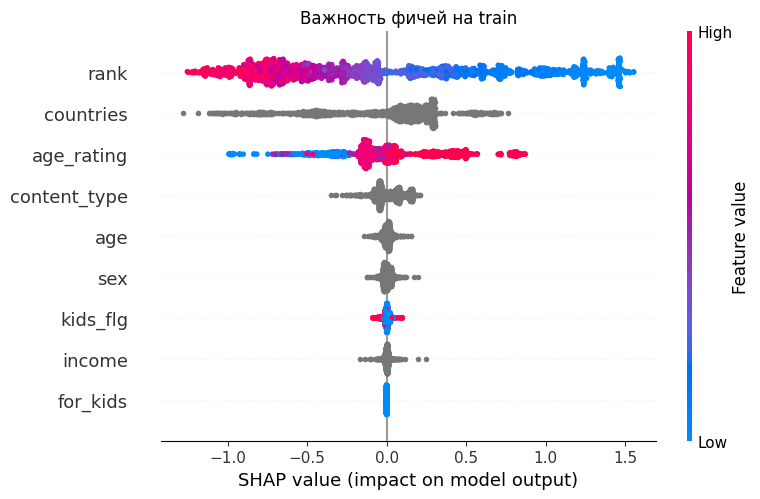

In [337]:
plt.title("Важность фичей на train")

shap.summary_plot(
    shap_values,
    X_train_subs
)

In [340]:
y_pred = ctb_model.predict(test_pool)
from sklearn.metrics import roc_auc_score

# f"ROC AUC score = {roc_auc_score(y_test, y_pred[:, 1]):.2f}"

# Рассчет метрики ROC-AUC
roc_auc = roc_auc_score(y_test, y_pred)

# Вывод результатов
print("Предсказания (Predictions):", y_pred)
print("Истинные метки (True Labels):", y_test.values)
print("ROC-AUC:", roc_auc)

Предсказания (Predictions): [ 2.17526423  1.45152435  1.04051236 ... -0.81757132  2.44600832
 -1.65800941]
Истинные метки (True Labels): [1 1 1 ... 0 0 0]
ROC-AUC: 0.787820011374186


In [341]:
# оставляем только теплых пользователей
test_2_level_global = test_2_level_global[test_2_level_global['user_id'].isin(lfm_train['user_id'].unique())]

In [342]:
recs_lightFM_2_level_global= model_LightFM_features_2_level_train.recommend(
    test_2_level_global.user_id.unique(),
    dataset=dataset_feature_lightFM_2_level_train,
    k=200,
    filter_viewed=True  # True - удаляет просмотренные айтемы из рекомендаций
)

# recs_lfm_pred_2_level_all_features = recs_lightFM_2_level_train.merge(items[['item_id', 'title']],
#                                on='item_id',
#                                how='left')
# recs_lfm_pred_2_level_all_features.head(10)

In [343]:
lfm_ctb_prediction = recs_lightFM_2_level_global.copy()

# фичи для теста
score_feat = lfm_ctb_prediction.merge(users[user_col],
                                   on=['user_id'],
                                   how='left')\
                                .merge(items[item_col],
                                       on=['item_id'],
                                       how='left')

# fillna for catboost with the most frequent value
score_feat = score_feat.fillna(X_train.mode().iloc[0])
score_feat

,user_id,item_id,score,rank,age,income,sex,kids_flg,content_type,countries,for_kids,age_rating
0,974013,15297,-45.165005,1,age_25_34,income_20_40,М,0.0,series,Россия,0.0,18.0
1,974013,10440,-45.168526,2,age_25_34,income_20_40,М,0.0,series,Россия,0.0,18.0
2,974013,4151,-45.822906,3,age_25_34,income_20_40,М,0.0,series,Россия,0.0,18.0
3,974013,142,-46.167656,4,age_25_34,income_20_40,М,0.0,film,Россия,0.0,16.0
4,974013,2657,-46.214157,5,age_25_34,income_20_40,М,0.0,series,Россия,0.0,16.0
...,...,...,...,...,...,...,...,...,...,...,...,...
553395,850716,7189,-47.817245,196,age_25_34,income_20_40,Ж,0.0,film,Италия,0.0,16.0
553396,850716,3296,-47.820648,197,age_25_34,income_20_40,Ж,0.0,film,Россия,0.0,18.0
553397,850716,12609,-47.824142,198,age_25_34,income_20_40,Ж,0.0,film,"Испания, Франция, Швеция, Аргентина",0.0,18.0
553398,850716,7806,-47.826611,199,age_25_34,income_20_40,Ж,0.0,film,Дания,0.0,18.0


In [346]:

ctb_prediction = ctb_model.predict(score_feat.drop(['user_id', 'item_id','score'], axis=1, errors='ignore'))

lfm_ctb_prediction['ctb_pred'] = ctb_prediction
lfm_ctb_prediction

,user_id,item_id,score,rank,ctb_pred
0,974013,15297,-45.165005,1,1.998160
1,974013,10440,-45.168526,2,1.899280
2,974013,4151,-45.822906,3,1.404747
3,974013,142,-46.167656,4,1.169669
4,974013,2657,-46.214157,5,0.958305
...,...,...,...,...,...
553395,850716,7189,-47.817245,196,-1.162230
553396,850716,3296,-47.820648,197,-0.511266
553397,850716,12609,-47.824142,198,-1.142528
553398,850716,7806,-47.826611,199,-1.426684


In [347]:
recs_lightFM_2_level_global.sort_values(
    by=['user_id'], ascending=[True]).head(10)

,user_id,item_id,score,rank
291200,53,15297,-42.588802,1
291327,53,10942,-44.929012,128
291328,53,3792,-44.936943,129
291329,53,14,-44.938599,130
291330,53,16166,-44.946007,131
291331,53,366,-44.951759,132
291332,53,6006,-44.955551,133
291333,53,12820,-44.962223,134
291334,53,11345,-44.966358,135
291335,53,7662,-44.969490,136


In [348]:
# сортируем по скору внутри одного пользователя и проставляем новый ранг
lfm_ctb_prediction = lfm_ctb_prediction.sort_values(
    by=['user_id', 'ctb_pred'], ascending=[True, False])
lfm_ctb_prediction['rank_ctb'] = lfm_ctb_prediction.groupby('user_id').cumcount() + 1
lfm_ctb_prediction.head(10)

,user_id,item_id,score,rank,ctb_pred,rank_ctb
291200,53,15297,-42.588802,1,2.175264,1
291201,53,9728,-42.856441,2,1.871992,2
291202,53,4151,-42.874390,3,1.451524,3
291203,53,4880,-43.070492,4,1.249987,4
291204,53,3734,-43.151005,5,1.040512,5
291205,53,6809,-43.170696,6,0.728307,6
291207,53,142,-43.246140,8,0.444720,7
291208,53,2657,-43.268456,9,0.269780,8
291235,53,11754,-44.217293,36,0.173224,9
291294,53,15739,-44.766724,95,0.173224,10


In [349]:
# интересно сравнить ранки 1 этапа lightfm и двухэтапной модели
pd.crosstab(lfm_ctb_prediction[lfm_ctb_prediction['rank'] <= 10]['rank'],
            lfm_ctb_prediction[lfm_ctb_prediction['rank_ctb'] <= 10]['rank_ctb'])\
    .style.background_gradient(cmap='spring')

rank_ctb,1,2,3,4,5,6,7,8,9,10
rank,,,,,,,,,,
1,2031,284,131,36,44,23,26,26,27,40
2,455,1533,293,76,60,56,31,22,32,26
3,108,384,966,759,191,33,23,14,17,24
4,71,213,413,768,642,145,62,29,29,45
5,25,114,220,435,749,556,102,75,31,21
6,12,45,104,110,264,575,474,295,245,68
7,5,25,97,36,89,203,379,424,451,331
8,7,28,85,26,48,111,226,351,459,441
9,2,14,88,30,19,40,112,237,292,463


In [350]:
recs_lightFM_2_level_global

,user_id,item_id,score,rank
0,974013,15297,-45.165005,1
1,974013,10440,-45.168526,2
2,974013,4151,-45.822906,3
3,974013,142,-46.167656,4
4,974013,2657,-46.214157,5
...,...,...,...,...
553395,850716,7189,-47.817245,196
553396,850716,3296,-47.820648,197
553397,850716,12609,-47.824142,198
553398,850716,7806,-47.826611,199


In [351]:
gfr = lfm_ctb_prediction.rename(columns={'rank_ctb': 'rank_1'})
lghtFM_cb_recs = gfr[['user_id','item_id','rank_1']].rename(columns={'rank_1': 'rank'})
lghtFM_cb_recs

,user_id,item_id,rank
291200,53,15297,1
291201,53,9728,2
291202,53,4151,3
291203,53,4880,4
291204,53,3734,5
...,...,...,...
287779,1097034,3134,196
287645,1097034,14120,197
287690,1097034,12225,198
287799,1097034,1978,199


In [352]:
from rectools.metrics import (calc_metrics, MeanInvUserFreq,
                              AvgRecPopularity, MAP, NDCG, CoveredUsers,HitRate,
                              CatalogCoverage,Intersection,Serendipity)

recs = {
    "pop": pop_recs,
    "pop_cat": pop_recs_cat,
    # "ease_recs": ease_recs,
    'iALS_recs':iALS_recs,
    'iALS_recs_BPR': iALS_recs_BPR,
    'LightFM_recs':LightFM_recs,
    'LightFM_recs_features':LightFM_recs_features,
    'LightFM_recs_features_all':LightFM_recs_features_all,
    'iALS_recs_BPR_features_all':iALS_recs_BPR_features_all,
    'recs_lfm_pred_2_level_all_features':recs_lfm_pred_2_level_all_features,
    'recs_lightFM_2_level_global_test':recs_lightFM_2_level_global,
    'lfm_ctb_prediction':lghtFM_cb_recs
}

metrics= {
    'map@10': MAP(k=10), # качество ранжирования
    "novelty": MeanInvUserFreq(k=10), # глобальная новизна
    "arp": AvgRecPopularity(k=10),  # popularity bias
    "ndcg": NDCG(k=10),
    "covarege": CoveredUsers(k=10),
    "hitrate": HitRate(k=10),
    "Intersection":Intersection(k=10),
    "Serendipity@10": Serendipity(k=10)

}

metrics_dict = {}
for model_name, recs_1 in recs.items():
    metrics_dict[model_name] = calc_metrics(
        metrics=metrics,
        reco=recs_1,
        interactions=test,
        prev_interactions=train,
        catalog=train['user_id'].unique(),
        # ref_reco=["popular"]
        ref_reco = {"same_model": recs_1}
    )


pd.DataFrame(metrics_dict).T

,hitrate,ndcg,map@10,novelty,arp,Serendipity@10,Intersection_same_model,covarege
pop,0.240221,0.034009,0.060381,3.435721,4994.000000,0.000000e+00,1.0,1.000000
pop_cat,0.236429,0.032148,0.057388,3.726594,4715.800000,7.404532e-07,1.0,1.000000
iALS_recs,0.029812,0.003095,0.005494,9.641614,358.225349,3.498760e-06,1.0,1.000000
iALS_recs_BPR,0.169567,0.025987,0.050664,7.893512,2918.941065,6.218636e-07,1.0,1.000000
LightFM_recs,0.245390,0.034412,0.060768,3.455764,4967.088971,1.317663e-07,1.0,1.000000
LightFM_recs_features,0.259866,0.035523,0.060554,3.918726,4458.545304,4.116232e-06,1.0,1.000000
LightFM_recs_features_all,0.244012,0.033996,0.059133,3.975516,4364.391298,2.617757e-06,1.0,1.000000
iALS_recs_BPR_features_all,0.170084,0.024590,0.046271,7.895017,2919.509288,9.230959e-07,1.0,1.000000
recs_lfm_pred_2_level_all_features,0.071515,0.010174,0.018542,4.273297,3697.481846,1.011918e-06,1.0,0.380665
recs_lightFM_2_level_global_test,0.097880,0.014027,0.028814,4.306270,3699.578533,3.903338e-06,1.0,0.476822
